# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sklearn
import imgaug
import tensorflow as tf
import random
import cv2
import os
import pickle # to save the model

from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import check
from ThreadPool import ThreadPool
    

# Check the version of the packages, you can skip this if you are not encountering any errors
check.version(np, "1.25.2")
check.version(tf, "2.15.0")
check.version(keras, "2.15.0")
check.version(sklearn, "1.2.2")
check.version(imgaug, "0.4.0")


numpy version: 1.25.2 ✅
tensorflow version: 2.15.0 ✅
keras version: 2.15.0 ✅
sklearn version: 1.2.2 ✅
imgaug version: 0.4.0 ✅


# Init ThreadPool

In [2]:
THREAD_COUNT = os.cpu_count()

# Create thread pool with number of threads equal to CPU cores count
thread_pool = ThreadPool(num_threads=THREAD_COUNT, verbose=False)

# Load Dataset

In [3]:
# Read dataset
PROJECT_DIR = os.path.join(os.getcwd(), "..") # Get the project directory, assuming the script is in the src folder
DATASET_TYPE = "enhanced" # "enhanced" or "original"
DATASET = [
    "Real",
    "Altered/Altered-Easy",
    "Altered/Altered-Medium",
    "Altered/Altered-Hard",
]
imgs_dict = {
    dataset: np.load(os.path.join(PROJECT_DIR, f"dataset-{DATASET_TYPE}", dataset, "imgs.npz"))["arr_0"]
    for dataset in DATASET
}
labels_dict = {
    dataset: np.load(os.path.join(PROJECT_DIR, f"dataset-{DATASET_TYPE}", dataset, "labels.npy"))
    for dataset in DATASET
}

print(f"Shape of Real dataset: {imgs_dict['Real'].shape}")
print(f"Shape of Altered-Easy dataset: {imgs_dict['Altered/Altered-Easy'].shape}")
print(f"Shape of Altered-Medium dataset: {imgs_dict['Altered/Altered-Medium'].shape}")
print(f"Shape of Altered-Hard dataset: {imgs_dict['Altered/Altered-Hard'].shape}")

Shape of Real dataset: (6000, 90, 90, 1)
Shape of Altered-Easy dataset: (17931, 90, 90, 1)
Shape of Altered-Medium dataset: (17067, 90, 90, 1)
Shape of Altered-Hard dataset: (14272, 90, 90, 1)


# Train Test Split

In [27]:
img_data = np.concatenate(list(imgs_dict.values()), axis=0)
label_data = np.concatenate(list(labels_dict.values()), axis=0)

img_train, img_val, label_train, label_val = sklearn.model_selection.train_test_split(img_data, label_data, test_size=0.1)

print(f"Shape of img_train: {img_train.shape}")
print(f"Shape of img_val: {img_val.shape}")
print(f"Shape of label_train: {label_train.shape}")
print(f"Shape of label_val: {label_val.shape}")

Shape of img_train: (49743, 90, 90, 1)
Shape of img_val: (5527, 90, 90, 1)
Shape of label_train: (49743, 4)
Shape of label_val: (5527, 4)


# Preview Augmentation

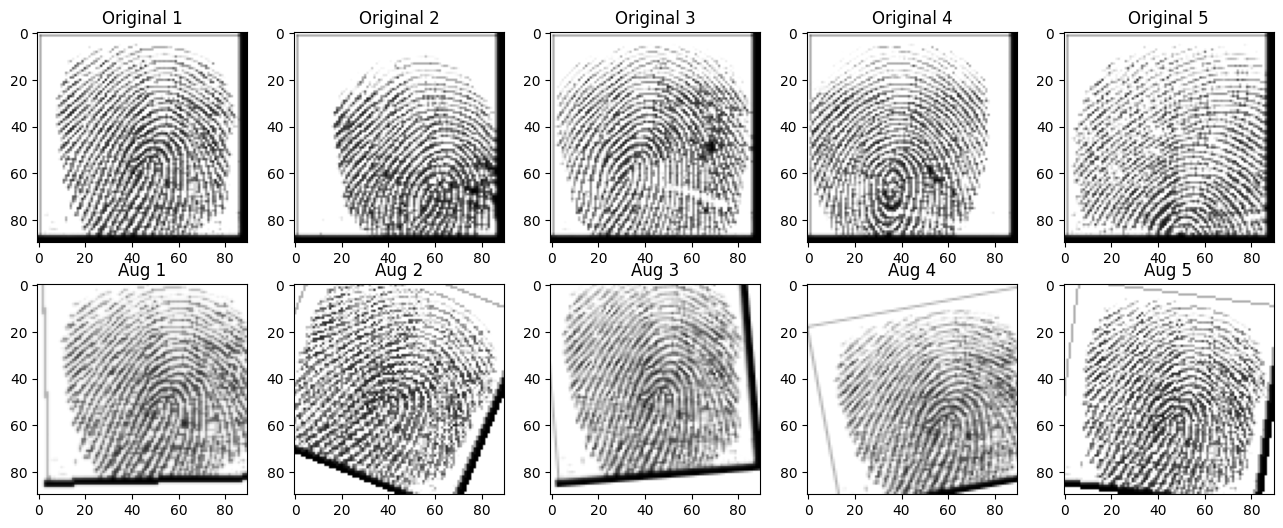

In [13]:
augs = [img_data[0]] * 5

seq = iaa.Sequential([
    # blur images with a sigma of 0 to 0.5
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate=(-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order=[0, 1],
        # if mode is constant, use a cval between 0 and 255
        cval=255
    )
], random_order=True)

augs = seq.augment_images(augs)
plt.figure(figsize=(16, 6))

# Preview original
for i, img in enumerate(img_data[:5]):
    plt.subplot(2, 5, i+1)
    plt.title(f'Original {i+1}')
    plt.imshow(img.squeeze(), cmap='gray')

# Preview augmentation
for i, aug in enumerate(augs):
    plt.subplot(2, 5, 5 + i+1)
    plt.title(f'Aug {i+1}')
    plt.imshow(aug.squeeze(), cmap='gray')

# Make Label Dictionary Lookup Table

In [8]:
label_real_dict = {}

for i, y in enumerate(labels_dict["Real"]):
    key = y.astype(str)
    key = ''.join(key).zfill(6)

    label_real_dict[key] = i

# Data Generator

In [26]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch = self.x[index*self.batch_size:(index+1)*self.batch_size]
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]

        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)

        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
            # for img in x1_batch:
            #     img = Gabor(img)

        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [28]:
train_gen = DataGenerator(img_train, label_train, imgs_dict["Real"], label_real_dict, shuffle=True)
val_gen = DataGenerator(img_val, label_val, imgs_dict["Real"], label_real_dict, shuffle=False)

# Create Model

In [10]:
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))
feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
feature = layers.MaxPooling2D(pool_size=2)(feature)
feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)
feature_model = Model(inputs=inputs, outputs=feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])
net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)
net = layers.Flatten()(net)
net = layers.Dense(64, activation='relu')(net)
net = layers.Dense(1, activation='sigmoid')(net)

# model
model = Model(inputs=[x1, x2], outputs=net)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 90, 90, 1)]          0         []                            
                                                                                                  
 model_2 (Functional)        (None, 22, 22, 32)           9568      ['input_4[0][0]',             
                                                                     'input_5[0][0]']             
                                                                                                  
 subtract_1 (Subtract)       (None, 22, 22, 32)           0         ['model_2[0][0]',       

# Train

In [29]:
history = model.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15


  96/1554 [>.............................] - ETA: 1:22 - loss: 0.4854 - acc: 0.7451

KeyboardInterrupt: 

# Save model

In [5]:
FILE_PATH = os.path.join(PROJECT_DIR, 'result/finalized_model.sav')
# pickle.dump(model, open(FILE_PATH, 'wb'))
loaded_model = pickle.load(open(FILE_PATH, 'rb'))

# Evaluation

1/1 [==============================] - 0s 26ms/step
0.49 2


C:\Users\khoakomlem\AppData\Local\Temp\ipykernel_22264\3941377275.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(round(float(pred_rx), 2), 2)
C:\Users\khoakomlem\AppData\Local\Temp\ipykernel_22264\3941377275.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('X: %.02f, %s' % (pred_ux, uy))


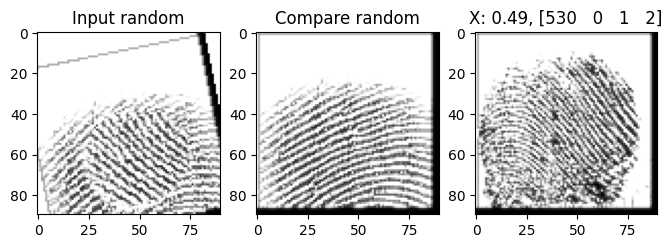

In [24]:
# new user fingerprint input
random_idx = random.randint(0, len(img_val))

random_img = img_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6)

rx = imgs_dict["Real"][label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = labels_dict["Real"][label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = imgs_dict["Real"][unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = labels_dict["Real"][unmatch_idx]

pred_ux = model.predict([random_img, ux])
print(round(float(pred_rx), 2), 2)

plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title(f"Input random")
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('Compare random')
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')

1/1 [==============================] - 0s 18ms/step
0.49 100001
1/1 [==============================] - 0s 19ms/step
0.5 100004
1/1 [==============================] - 0s 18ms/step
0.49 100002
1/1 [==============================] - 0s 23ms/step
0.49 100003
1/1 [==============================] - 0s 18ms/step
0.49 100000
1/1 [==============================] - 0s 18ms/step
0.5 100011
1/1 [==============================] - 0s 19ms/step
0.49 100014
1/1 [==============================] - 0s 19ms/step
0.49 100012
1/1 [==============================] - 0s 18ms/step
0.5 100013
1/1 [==============================] - 0s 19ms/step
0.5 100010
1/1 [==============================] - 0s 17ms/step
0.49 101001
1/1 [==============================] - 0s 16ms/step
0.49 101004
1/1 [==============================] - 0s 18ms/step
0.49 101002
1/1 [==============================] - 0s 24ms/step
0.49 101003
1/1 [==============================] - 0s 18ms/step
0.5 101000
1/1 [==============================] - 0s 18m

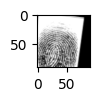

In [20]:
from gen_dataset_enhanced import Gabor # import the Gabor function from gen_dataset_enhanced.py

img = cv2.imread(os.path.join(PROJECT_DIR, './dataset-raw/Real/1__M_Left_index_finger.BMP'), cv2.IMREAD_GRAYSCALE)
img = Gabor(img)    

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=0
    )
], random_order=True)

img = seq.augment_image(img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

plt.subplot(1, 8, 1)
plt.imshow(img.squeeze(), cmap='gray')
count = 0

# Tìm kiếm kết quả phù hợp trong các ảnh đã đăng kí trước
for i in range(1000):
    tmp_x = imgs_dict["Real"][i].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
    tmp_y = labels_dict["Real"][i]
    tmp_y = tmp_y.astype(str)
    tmp_y = ''.join(tmp_y).zfill(6)
    pred = model.predict([img, tmp_x])
    score = round(np.max(pred), 2)
    print(score, tmp_y)
    
    if (score >= 0.8):
        break
        print("ASDOHASODUAJSD")
        count += 1
        plt.subplot(1, 5,count)
        plt.title("test")
        plt.imshow(imgs_dict["Real"][i].squeeze(), cmap='gray')